# Numerical integration 2
Some more theory.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from functools import partial

We would like to approximate $\int_a^b f$. The general form for a quadrature rule is given by $$\sum_{i=0}^{n-1} f(q_i) w_i$$. 
The weights $w_i$ depend on the quadrature formula we are using, $q_i$ are the only points in which we evaluate the function.

In general we are going to consider the approximation $$\int_a^b f \approx \int_a^b I^n f$$, which means that we replace the function with its polynomial approximation. For instance, if we consider Lagrange basis functions:
$$\int_a^b f \approx \int_a^b I^n f = \int_a^b \sum_{i=0}^{n-1} f(q_i) \ell(x) dx = \sum_{i=0}^{n-1} f(q_i) \int_a^b \ell(x) dx$$. Therefore $w_i = \int_a^b \ell$.

Remark: $$\displaystyle \ell_i(x) = \prod_{i \neq j, j=0}^{n-1} \frac{x-q_j}{q_i-q_j}$$.

In [4]:
N = 101
x = np.linspace(0,1,N)

In [5]:
# q: quadrature points
# x: evaluation point(s)
# i: index in the Lagrange basis
def lagrange(x, q, i):
    li = np.ones_like(x)
    for j in range(len(q)):
        if i != j:
            li = li * (x-q[j]) / (q[i]-q[j])
    return li

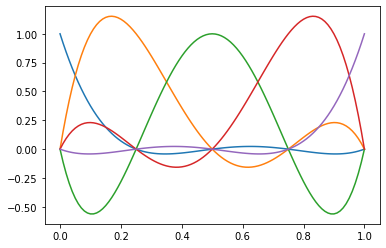

In [6]:
q = np.linspace(0,1,5)

[plt.plot(x,lagrange(x,q,i)) for i in range(len(q))];

With the monomial basis $\{v_i\}_{i=0}^{n-1} := \{x^i\}_{i=0}^{n-1}$ we can rewrite the Lagrange basis as $$\ell_i = V^{ij} v_j$$

where $V_{ij} = v_j q_i$ and $V^{ij}$ is the $ij$ index of $V_{ij}^{—1}$.

I **know** how to integrate monomials exactly, therefore I would like to switch the basis, from Lagrange to monomials. This is the purpose of $V^{ij}$.

In [7]:
def monomial(x,i):
    return np.power(x,i)

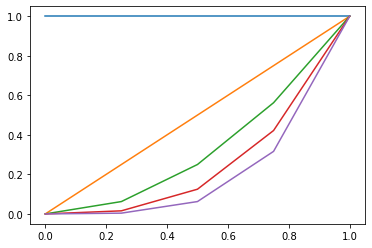

In [8]:
Nq = 5
# monomial basis
V = np.array([monomial(q,i) for i in range(Nq)]).T
plt.plot(q,V);

$V^{-1}$ contains the coefficients of the Lagrange basis functions with respect to the monomials basis functions:

In [9]:
Vinv = np.linalg.inv(V)

$$M_{\alpha i} := v_i (x_\alpha) = \texttt{pow}(x_a, i)$$
$$L_{\alpha j} := M_{\alpha i} V^{ij} := \ell_j (x_\alpha)$$

Therefore we recover the Lagrange basis functions via a matrix multiplication:

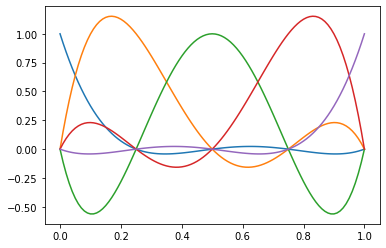

In [11]:
M = np.array([monomial(x,i) for i in range(Nq)]).T
L = M.dot(Vinv)

plt.plot(x, L);

[ -8.33333333  16.         -12.           5.33333333  -1.        ]


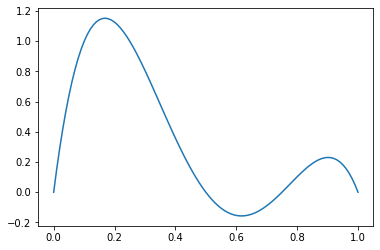

In [46]:
print(Vinv[1])
plt.plot(x, M.dot(Vinv[:,1]))

Now we have the monomial coefficients, therefore we can write the integral of the monimials explicitly:
$$\int_a^b x^i = \left. \frac{x^{i+1}}{i+1} \right|_b^a$$.

We now write a vector $W$ which is the integration of the monomial basis between the extreme points:
$$\{W_i\}_{i=0}^{n-1} = \left\{\int_a^b x^i dx\right\}_{i=0}^{n-1}$$

Therefore $\int_a^b f \approx \int_a^b \sum p_i x^i = \sum p_i W_i$.

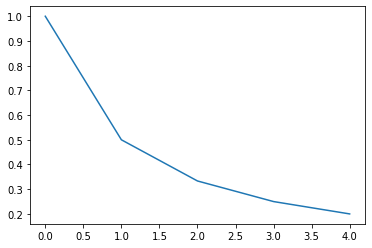

In [13]:
def integral_of_monomials(a,b,i):
    return (b**(i+1) - a**(i+1)) / (i+1)

W = np.array([integral_of_monomials(0,1,i) for i in range(Nq)])
plt.plot(W);

We now compute $w$ (small) which contains the integrals of $\ell_i$:

(5,)

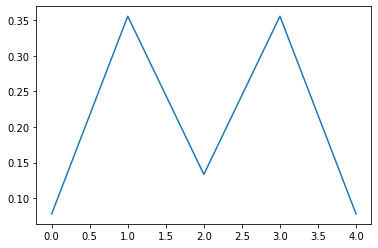

In [14]:
w = W.dot(Vinv)
plt.plot(w)
w.shape

We generalize the procedure:

In [39]:
def weights_of_quadrature_rule(q,a,b):
    Nq = len(q)
    V = np.array([q**i for i in range(Nq)]).T
    Vinv = np.linalg.inv(V)
    W = np.array([integral_of_monomials(a,b,i) for i in range(Nq)])
    return W.dot(Vinv)

def quadrature_general_integration(f,w,q,a,b):
    return np.inner(w, f(q))

def integrate(f,q,a,b):
    return quadrature_general_integration(f,weights_of_quadrature_rule(q,a,b),q,a,b)

In [40]:
integrate(np.sin, np.linspace(0,np.pi,10), 0,np.pi)

1.9999998948482025

## Checks

Let's check basic identities:
$$\int_a^b p = \sum_{i=0}^{n-1} p(q_i) w_i \quad \forall p \in \mathbb{P}^k(a,b), k \leq n-1$$

In [24]:
def monomials_error(q,a,b,i):
    def mono(x):
        return np.power(x,i)
    
    exact = integral_of_monomials(a,b,i)
    computed = integrate(mono, q, a, b)
    return np.abs(exact - computed)

def monomials_error_with_weights(q,w,a,b,i):
    def mono(x):
        return np.power(x,i)
    
    exact = integral_of_monomials(a,b,i)
    computed = np.power(q,i).dot(w)
    return np.abs(exact - computed)

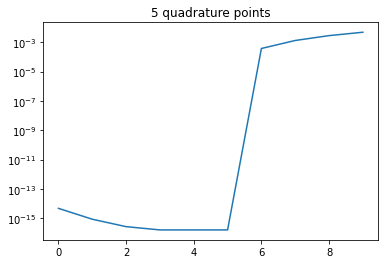

In [23]:
q = np.linspace(0,1,5)
g = list(range(10))
plt.semilogy(g, [monomials_error(q,0,1,i) for i in g])
plt.title('{} quadrature points'.format(len(q)))
plt.show()

Note that we get *for free* error zero for polynomyals of degree $5=N_q$, which is unexepected. This happens because the polynomial is symmetric with respect to the central point.

# Gauss quadrature rules

Gauss-Legendre quadrature nodes are the *optimal* ones, which means that using those points we reach an accuracy degree of $k=2n-1$. In the example above we would have got error almost zero up to polynomial degree 9.

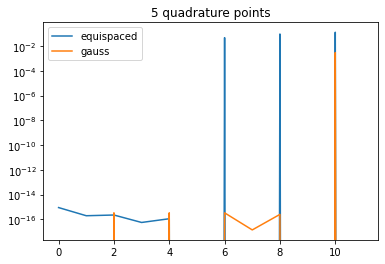

In [29]:
# control points and weights for Gauss
qg, wg = np.polynomial.legendre.leggauss(Nq)

degrees = list(range(2*Nq+2))

q = np.linspace(-1,1,Nq)

plt.semilogy(degrees, [monomials_error(q,-1,1,i) for i in degrees], label='equispaced')
plt.semilogy(degrees, [monomials_error_with_weights(qg,wg,-1,1,i) for i in degrees], label='gauss')

plt.title('{} quadrature points'.format(len(q)))
plt.legend()

plt.show()

Again we get symmetry for odd polynomials, the integral evaluates to zero, and we get small error for these cases. The error comes in as soon as we increase the polynomial degree to much.

### Remark
If we did everything correctly, the weights in the Gauss points should coincide with those returned by `leggauss`.

In [50]:
Nq = 5
q,w = np.polynomial.legendre.leggauss(Nq)
myw = weights_of_quadrature_rule(q,-1,1)
w - myw

array([3.33066907e-16, 1.11022302e-16, 2.22044605e-16, 1.11022302e-16,
       2.22044605e-16])

In [81]:
def scale_gauss(a,b,Nq):
    qg, wg = np.polynomial.legendre.leggauss(Nq)
    # I need to translate/scale everything if I want to change the
    # interval (the original one is [-1,1])
    qg = (qg+1)*(b-a)/2+a
    
    return qg, weights_of_quadrature_rule(qg,a,b)

def scale_cheby(a,b,Nq):
    qc, wc = np.polynomial.chebyshev.chebgauss(Nq)
    # I need to translate/scale everything if I want to change the
    # interval (the original one is [-1,1])
    qc = (qc+1)*(b-a)/2+a
    
    return qc, weights_of_quadrature_rule(qc,a,b)

def gauss_vs_equi_vs_chebyshev_iteratedtrapezoidal(f,a,b,N, expected):
    equi = []
    gauss = []
    cheby = []
    iter_trap = []
    for Nq in range(1,N):
        q = np.linspace(a,b,Nq)
        qc, wc = scale_cheby(a,b,Nq)
        qg, wg = scale_gauss(a,b,Nq)
        
        wa = np.ones_like(q) / len(q)*(b-a)
        
        equi.append(integrate(f,q,a,b))
        cheby.append(quadrature_general_integration(f,wc,qc,a,b))
        gauss.append(quadrature_general_integration(f,wg,qg,a,b))
        iter_trap.append(f(q).dot(wa))

    plt.semilogy(range(1,N), np.abs(np.array(equi) - expected), label='equispaced')
    plt.semilogy(range(1,N), np.abs(np.array(cheby) - expected), label='chebyshev')
    plt.semilogy(range(1,N), np.abs(np.array(gauss) - expected), label='gauss')
    plt.semilogy(range(1,N), np.abs(np.array(iter_trap) - expected), label='iterated-trapezoidal')
        
    plt.legend()

    plt.show()

Let's compare the results on our test function:

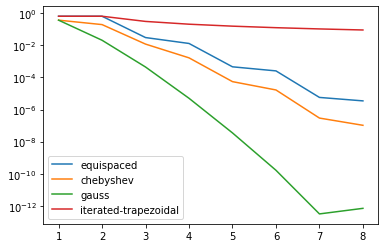

In [82]:
def my_func(x):
    # the expected integral in [0,1] is 2/pi
    return np.sin(x * np.pi)

gauss_vs_equi_vs_chebyshev_iteratedtrapezoidal(my_func, 0,1, 9, 2/np.pi)

Chebyshev is optimized for interpolation, not integration.

What happens with a function which is not $C^\infty$?

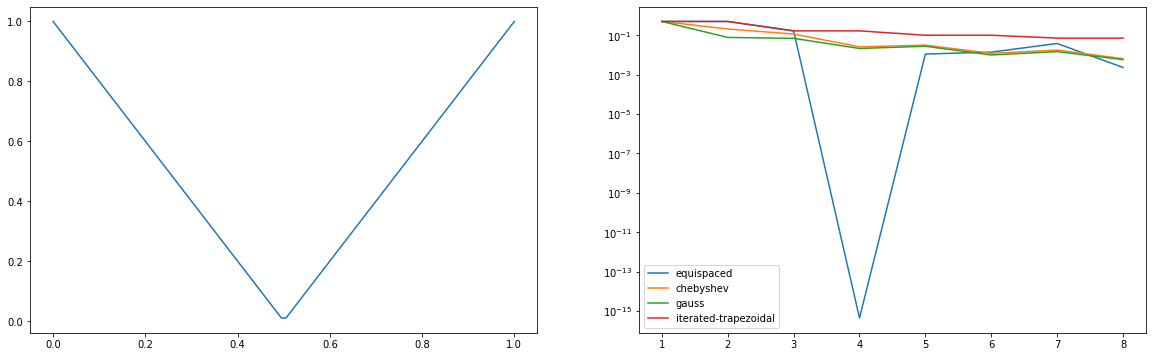

In [83]:
def my_func2(x):
    # the expected integral in [0,1] is 2/pi
    return 2*np.abs(x-.5)

plt.figure(figsize=(20,6))

plt.subplot(1,2,1)
plt.plot(np.linspace(0,1,100),my_func2(np.linspace(0,1,100)))

plt.subplot(1,2,2)
gauss_vs_equi_vs_chebyshev_iteratedtrapezoidal(my_func2, 0,1, 9, 0.5)

Professor's integral was exact in $N_q=3$ since **by chance** we got the right three quadrature points which gave us the results.

What happens for more points?

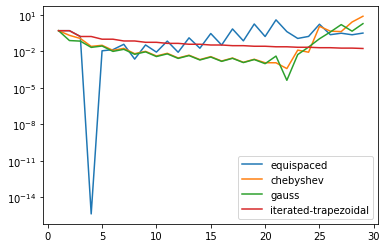

In [84]:
gauss_vs_equi_vs_chebyshev_iteratedtrapezoidal(my_func2, 0,1, 30, 0.5)

The explosion of error comes from:
+ summation of calculation errors;
+ inverse matrix.